# Baseline model training (with outliters)

**Without removing outliers with the OutlierImputter class**, we train some simple models:
- Linear models
- Support Vector Machines (they take a long to train, given the dimensionality of the data, so they are discarded)
- KNN
- Trees
- Random forests

Along with that, there are some nice plots that may give super interesting info, but I did not have much time to think carefully about them.

## Import standard libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import time
from sklearn.preprocessing import StandardScaler

## Import custom scripts

In [2]:
import sys, os
sys.path.append(os.getcwd()+ "/../")
from src.data_preprocessing import DataPreprocessing

## Load all the features
The datapreprocessing pipeline is doing quite some stuff, and in a non-efficient manner (I don't have much time for optimizing that :( )
But it should be less than 2 min

In [3]:
dp = DataPreprocessing(df_path = "../data/real_estate_ads_2022_10.csv",
                        train_indices_path="../data/train_indices.npy", 
                        test_indices_path="../data/test_indices.npy",
                        get_params_from_params=True,
                        get_tfidf_embeddings_flag=True,
                        get_bert_embeddings_flag=True,
                        get_textual_features_flag=True,
                        transform_time_features_flag=True,
                        transform_cyclic_features_flag=True)

## Load the metrics class
That is convenient to compute multiple metrics:
- **explained_variance_score**: Measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A score of 1 indicates perfect prediction, while a score of 0 indicates that the model does not explain any of the variance.

- **r2_score**: Also known as the coefficient of determination, it indicates the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A value of 1 indicates a perfect fit, while a value of 0 indicates that the model does not explain any of the variance.

- **mean_absolute_percentage_error (MAPE)**: Measures the average of the absolute percentage errors of predictions. It provides a percentage error which is easy to interpret but can be sensitive to very small actual values.

- **median_absolute_error**: Computes the median of all absolute differences between the target and predicted values. This metric is robust to outliers and gives a better sense of the typical error when outliers are present.

- **mean_squared_error (MSE)**: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. It penalizes larger errors more than smaller ones due to squaring.

- **mean_squared_log_error (MSLE)**: Similar to MSE but takes the logarithm of the predictions and actual values. It is useful when you want to penalize underestimation more than overestimation and is less sensitive to large errors than MSE.

- **custom metrics**: Compute the percentage of times that the error falls less than some threshold. This may correlate with customer satisfaction, if they are for example happy if there's less than a 5% rate, this would count the percentage of happy customers. Of course, this will need further study (for example, segmenting the score)

In [16]:
import importlib
import src.compute_metrics
importlib.reload(src.compute_metrics) # We do this for debugging purposes

from src.compute_metrics import Metrics

## Split train / test data
We can use the datapreprocessing method for that.

This is done for better reproducibility, but can be done with the sklearn train / test split, and setting a seed should suffice.

In [17]:
X_train, X_test = dp.get_train_test_split(dp.X)
y_train, y_test = dp.get_train_test_split(dp.Y)

## Impute NaNs
This is usually required for these kind of models (non-gradient boosting).

We will use a simple strategy (impute the mean)

In [18]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = pd.DataFrame(imp_mean.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns=X_test.columns)

## Define a function for training
We will use k-fold cross-validation

In [19]:
def train_and_get_metrics(model, X, y, backward_transform_label=True, backward_standardize_flag=False, verbose=False,
                        standard_scale_flag=False):

    metrics = Metrics(dp=dp, backward_transform_flag=backward_transform_label, backward_standardize_flag=backward_standardize_flag)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        if standard_scale_flag:
            scaler = StandardScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
            X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        if verbose: 
            print(f"y_pred: {y_pred[:5]}")
            print(f"y_val: {y_val[:5]}")
            
        computed_metrics = metrics.get_single_train_val_metrics(model, X_train, y_train, X_val, y_val)
        metrics.append(computed_metrics)

    average_metrics = metrics.get_average()
    std_metrics = metrics.get_std()
    # Add _std to the keys to differentiate them from the average metrics:
    std_metrics = {f"{key}_std" : value for key, value in std_metrics.items()} 

    return {**average_metrics, **std_metrics}

## Define convenience functions for prettier display

In [20]:
def filter_metrics(metrics_dict, only_validation=True, format_mean_std_together=True):

    if only_validation:
        metrics_dict = {key: value for key, value in metrics_dict.items() if "test_" in key}

    if format_mean_std_together:
        metrics_dict = {key: f"{value:.2f} ± {metrics_dict[key+'_std']:.2f}" for key, value in metrics_dict.items() if "std" not in key}

    return metrics_dict

def highlight_max(s):
    is_max = s == s.replace("nan ± nan", "0").apply(lambda x: x.split("+-")[0]).max()
    return ['font-weight: bold' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.replace("nan ± nan", "0").apply(lambda x: x.split("+-")[0]).min()
    return ['font-weight: bold' if v else '' for v in is_min]

def format_results_df(results, column_names=None):
    results_df = pd.DataFrame(results).T

    if column_names is not None:
        results_df.columns = column_names
    
    def apply_highlight(column):
        if column.name in ["test_explained_variance", "test_r2", "test_custom_1", "test_custom_5", "test_custom_10", "test_custom_20"]:
            return highlight_max(column)
        else:
            return highlight_min(column)

    
    return results_df.style.apply(apply_highlight, axis=1)

# Import and define baseline models

In [39]:
# Use simple linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Support vector machines
from sklearn.svm import SVR

# K neighbors classifiers
from sklearn.neighbors import KNeighborsRegressor

# Decision trees
from sklearn.tree import DecisionTreeRegressor

# Random forests
from sklearn.ensemble import RandomForestRegressor

## Linear models

### Without standardizing

In [22]:
linear_models = {
    "Linear regression" : {
        "model": LinearRegression(),
        },
    "Lasso" : {
        "model": Lasso(),
        },
    }

results_list = []

for model_name in linear_models:
    print(model_name)
    model = linear_models[model_name]["model"]

    results = train_and_get_metrics(model, X_train, y_train, standard_scale_flag=False)
    results_list.append(results)

filtered_results = [filter_metrics(results) for results in results_list]
format_results_df(filtered_results, column_names=linear_models.keys())

Linear regression
Lasso


,Linear regression,Lasso
test_explained_variance,0.40 ± 0.05,0.08 ± 0.01
test_r2,0.40 ± 0.05,0.07 ± 0.01
test_mape,1231.89 ± 144.88,1367.78 ± 146.44
test_median_absolute_error,740.79 ± 5.92,1025.77 ± 6.85
test_mean_absolute_error,1041.50 ± 6.14,1396.00 ± 9.68
test_mean_squared_log_error,0.25 ± 0.03,0.28 ± 0.03
test_custom_1,5.87 ± 0.12,4.11 ± 0.25
test_custom_5,28.38 ± 0.25,20.38 ± 0.42
test_custom_10,52.70 ± 0.34,39.83 ± 0.28
test_custom_20,82.22 ± 0.33,68.88 ± 0.39


### Standardizing

In [23]:
linear_models = {
    "Linear regression" : {
        "model": LinearRegression(),
        },
    "Lasso" : {
        "model": Lasso(),
        },
    }

results_list = []

for model_name in linear_models:
    print(model_name)
    model = linear_models[model_name]["model"]

    results = train_and_get_metrics(model, X_train, y_train, standard_scale_flag=True)
    results_list.append(results)

filtered_results = [filter_metrics(results) for results in results_list]
format_results_df(filtered_results, column_names=linear_models.keys())

Linear regression
Lasso


,Linear regression,Lasso
test_explained_variance,0.40 ± 0.05,0.00 ± 0.00
test_r2,0.40 ± 0.05,-0.01 ± 0.00
test_mape,1231.90 ± 144.89,1389.03 ± 151.34
test_median_absolute_error,740.34 ± 5.89,1096.21 ± 5.13
test_mean_absolute_error,1041.49 ± 6.13,1478.95 ± 10.83
test_mean_squared_log_error,0.25 ± 0.03,0.28 ± 0.03
test_custom_1,5.88 ± 0.12,3.97 ± 0.18
test_custom_5,28.37 ± 0.24,19.48 ± 0.10
test_custom_10,52.70 ± 0.33,37.44 ± 0.27
test_custom_20,82.22 ± 0.33,66.59 ± 0.37


## Support Vector Machines
***IMPORTANT NOTE***: SVR takes too long due to the dimensionality of the problem (specially the number of samples).

There are some tricks to overcome this, like using CPU-accelerator given by intel.

For time reasons, here we sample only 10 000 samples.

In [24]:
%%capture
# WE GET LOTS OF WARNINGS HERE
# SINCE WE SET MAX_ITER TO A VERY LOW VALUE
# SO WE CAPTURE (IGNORE) THEM

SVR_models = {
    "SVR linear" : {
        "model": SVR(kernel="linear", max_iter=1000),
        },
    "SVR polynomial" : {
        "model": SVR(kernel="poly", max_iter=1000),
        },
    "SVR rbf" : {
        "model": SVR(kernel="rbf", max_iter=1000),
        },
    "SVR sigmoid" : {
        "model": SVR(kernel="sigmoid", max_iter=1000),
        }}

results_svr_list = []

for model_name in SVR_models:
    print(model_name)
    model = SVR_models[model_name]["model"]

    results = train_and_get_metrics(model, X_train.sample(10000, random_state=1), y_train.sample(10000, random_state=1), verbose=False)
    results_svr_list.append(results) 

In [25]:
filtered_results_svr = [filter_metrics(results) for results in results_svr_list]
format_results_df(filtered_results_svr, column_names=SVR_models.keys())

,SVR linear,SVR polynomial,SVR rbf,SVR sigmoid
test_explained_variance,-691859616716730862981854539876449655865829433779683328.00 ± 1055144418443365147277044336421238948875019132761800704.00,-3.79 ± 6.35,-0.03 ± 0.04,-173337065.34 ± 51411803.12
test_r2,-742760377360117145848153940478606065971400891273576448.00 ± 1077870840785133397211671727957988976812943254386376704.00,-16.87 ± 7.98,-5.76 ± 3.11,-210547854.58 ± 62886063.55
test_mape,21688066565128401914714652672.00 ± 41125527664660254429374578688.00,1.01 ± 0.01,465.23 ± 532.99,2846.15 ± 2155.17
test_median_absolute_error,125546254599620307909284462592.00 ± 250978384341006432797833822208.00,7890.26 ± 40.10,4958.88 ± 1468.51,11085.20 ± 373.17
test_mean_absolute_error,355388966082856059071344148480.00 ± 323643966893441336231841497088.00,8255.23 ± 68.20,5287.38 ± 1432.76,13652570.28 ± 610279.10
test_mean_squared_log_error,1605.32 ± 769.97,80.37 ± 0.35,1.83 ± 1.25,67.87 ± 0.23
test_custom_1,0.00 ± 0.00,0.00 ± 0.00,0.11 ± 0.13,0.00 ± 0.00
test_custom_5,0.00 ± 0.00,0.00 ± 0.00,0.55 ± 0.74,0.04 ± 0.04
test_custom_10,0.00 ± 0.00,0.00 ± 0.00,1.01 ± 1.42,0.06 ± 0.04
test_custom_20,0.00 ± 0.00,0.00 ± 0.00,3.03 ± 4.12,0.13 ± 0.05


Results are poor, since the **max_iter** is only set for 1000.

One should train this models for longer time. They are quite capable.

However, for time reasons in our case, we just 'discard' them.

##  KNN

In [26]:
KN_models = {
    "KNN 1" : {
        "model": KNeighborsRegressor(n_neighbors=1),
        },
    "KNN 2" : {
        "model": KNeighborsRegressor(n_neighbors=2),
        },
    "KNN 3" : {
        "model": KNeighborsRegressor(n_neighbors=3),
        },
    "KNN 5" : {
        "model": KNeighborsRegressor(n_neighbors=5),
        },
    "KNN 7" : {
        "model": KNeighborsRegressor(n_neighbors=7),
        },
    "KNN 10" : {
        "model": KNeighborsRegressor(n_neighbors=10),
        }}

results_list_KN_models = []

for model_name in KN_models:
    print(model_name)
    model = KN_models[model_name]["model"]

    results = train_and_get_metrics(model, X_train.sample(500, random_state=1), y_train.sample(500, random_state=1), verbose=False)
    results_list_KN_models.append(results)

filtered_results_KN = [filter_metrics(results) for results in results_list_KN_models]
format_results_df(filtered_results_KN, column_names=KN_models.keys())

KNN 1
KNN 2
KNN 3
KNN 5
KNN 7
KNN 10


,KNN 1,KNN 2,KNN 3,KNN 5,KNN 7,KNN 10
test_explained_variance,-0.76 ± 0.37,-0.51 ± 0.36,-0.34 ± 0.22,-0.25 ± 0.23,-0.21 ± 0.16,-0.15 ± 0.15
test_r2,-0.81 ± 0.37,-0.54 ± 0.37,-0.36 ± 0.22,-0.29 ± 0.22,-0.24 ± 0.14,-0.17 ± 0.14
test_mape,3142.90 ± 4956.31,2568.69 ± 4047.15,2318.06 ± 3593.32,2255.49 ± 3251.51,2358.14 ± 3448.14,2229.79 ± 3337.55
test_median_absolute_error,1495.65 ± 172.73,1280.12 ± 132.38,1274.60 ± 161.90,1205.07 ± 54.08,1173.96 ± 107.23,1174.78 ± 110.25
test_mean_absolute_error,2035.10 ± 258.66,1852.90 ± 243.88,1742.51 ± 227.02,1678.57 ± 155.00,1628.69 ± 184.68,1602.88 ± 167.56
test_mean_squared_log_error,0.87 ± 0.81,0.55 ± 0.52,0.51 ± 0.52,0.50 ± 0.53,0.49 ± 0.53,0.48 ± 0.52
test_custom_1,4.80 ± 2.14,3.00 ± 1.10,4.20 ± 2.04,4.20 ± 1.60,5.20 ± 1.47,3.60 ± 1.36
test_custom_5,15.20 ± 2.32,16.60 ± 2.73,16.80 ± 2.23,18.20 ± 1.94,20.20 ± 3.43,20.20 ± 4.07
test_custom_10,26.80 ± 2.32,31.80 ± 5.46,34.60 ± 3.50,34.80 ± 2.14,35.80 ± 4.31,35.60 ± 4.32
test_custom_20,53.80 ± 5.15,58.00 ± 4.82,60.80 ± 4.07,60.80 ± 2.79,63.00 ± 3.74,64.00 ± 3.85


### Do a plot of metrics wrt neighbors

KNN 1
KNN 2
KNN 3
KNN 5
KNN 7
KNN 10
KNN 15
KNN 20
KNN 25
KNN 30
KNN 40
KNN 50
KNN 80
KNN 100
KNN 200


Text(0.5, 1.0, 'Metrics for different number of neighbors')

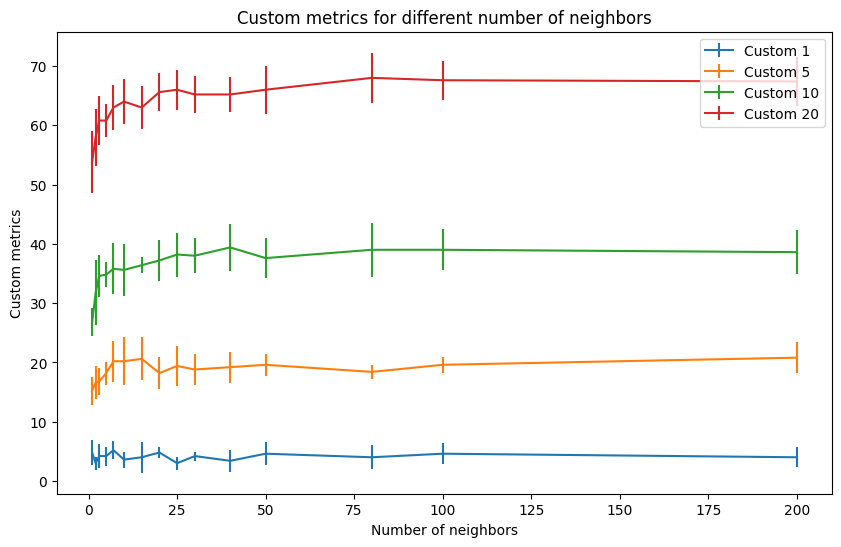

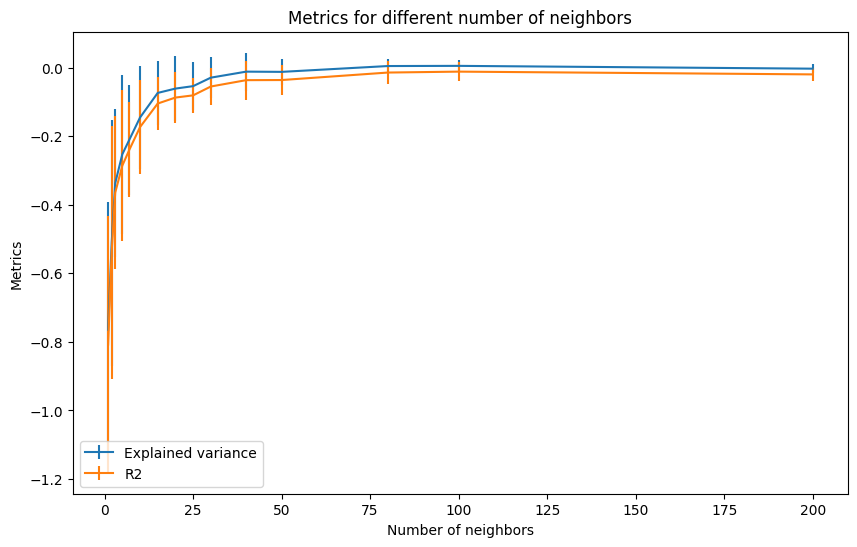

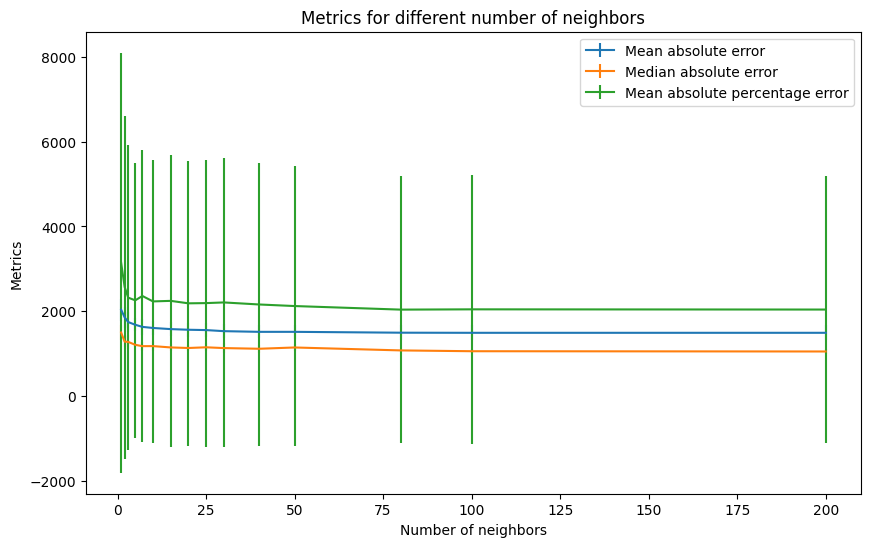

In [28]:
neighbors_tried = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 80, 100, 200]

KN_models_plot = {
    f"KNN {i}" : {
        "model": KNeighborsRegressor(n_neighbors=i),
        "use_probabilities": True,
        "convert_to_binary": False
        } for i in neighbors_tried}

results_list_KN_models_plot = []

for model_name in KN_models_plot:
    print(model_name)
    model = KN_models_plot[model_name]["model"]

    results = train_and_get_metrics(model, X_train.sample(500, random_state=1), y_train.sample(500, random_state=1), verbose=False)
    results_list_KN_models_plot.append(results)

plt.figure(figsize=(10, 6))
plt.errorbar(neighbors_tried, [results["test_custom_1"] for results in results_list_KN_models_plot], 
             yerr=[results["test_custom_1_std"] for results in results_list_KN_models_plot], label="Custom 1")
plt.errorbar(neighbors_tried, [results["test_custom_5"] for results in results_list_KN_models_plot],
                yerr=[results["test_custom_5_std"] for results in results_list_KN_models_plot], label="Custom 5")
plt.errorbar(neighbors_tried, [results["test_custom_10"] for results in results_list_KN_models_plot],
                yerr=[results["test_custom_10_std"] for results in results_list_KN_models_plot], label="Custom 10")    
plt.errorbar(neighbors_tried, [results["test_custom_20"] for results in results_list_KN_models_plot],
                yerr=[results["test_custom_20_std"] for results in results_list_KN_models_plot], label="Custom 20")
plt.xlabel("Number of neighbors")
plt.ylabel("Custom metrics")
plt.legend()
plt.title("Custom metrics for different number of neighbors")

plt.figure(figsize=(10, 6))
plt.errorbar(neighbors_tried, [results["test_explained_variance"] for results in results_list_KN_models_plot], 
             yerr=[results["test_explained_variance_std"] for results in results_list_KN_models_plot], label="Explained variance")
plt.errorbar(neighbors_tried, [results["test_r2"] for results in results_list_KN_models_plot],
                yerr=[results["test_r2_std"] for results in results_list_KN_models_plot], label="R2")
plt.xlabel("Number of neighbors")
plt.ylabel("Metrics")
plt.legend()
plt.title("Metrics for different number of neighbors")

# Now for ["test_mean_absolute_error", "test_median_absolute_error", "test_mape"]

plt.figure(figsize=(10, 6))
plt.errorbar(neighbors_tried, [results["test_mean_absolute_error"] for results in results_list_KN_models_plot], 
             yerr=[results["test_mean_absolute_error_std"] for results in results_list_KN_models_plot], label="Mean absolute error")
plt.errorbar(neighbors_tried, [results["test_median_absolute_error"] for results in results_list_KN_models_plot],
                yerr=[results["test_median_absolute_error_std"] for results in results_list_KN_models_plot], label="Median absolute error")
plt.errorbar(neighbors_tried, [results["test_mape"] for results in results_list_KN_models_plot],   
                yerr=[results["test_mape_std"] for results in results_list_KN_models_plot], label="Mean absolute percentage error")
plt.xlabel("Number of neighbors")
plt.ylabel("Metrics")
plt.legend()
plt.title("Metrics for different number of neighbors")

## Tree models

Tree with max depth 1
Tree with max depth 2
Tree with max depth 3
Tree with max depth 5
Tree with max depth 7
Tree with max depth 10
Tree with max depth 15
Tree with max depth 20
Tree with max depth 25
Tree with max depth 30
Tree with max depth 40
Tree with max depth 50
Tree with max depth 80
Tree with max depth 100
Tree with max depth 200


Text(0.5, 1.0, 'Metrics for different max depth')

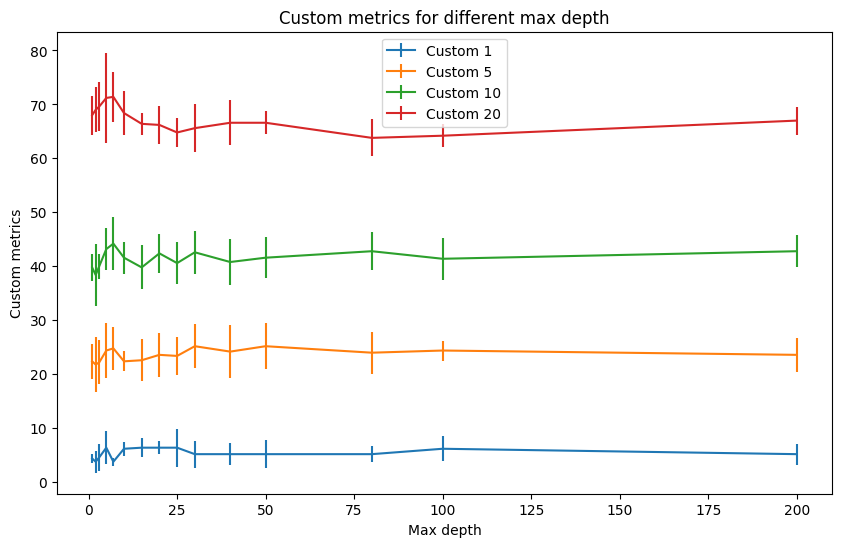

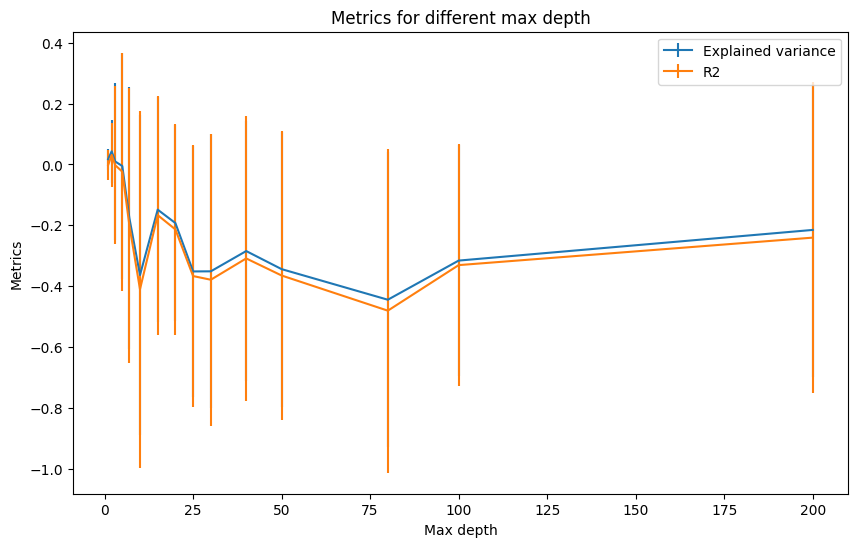

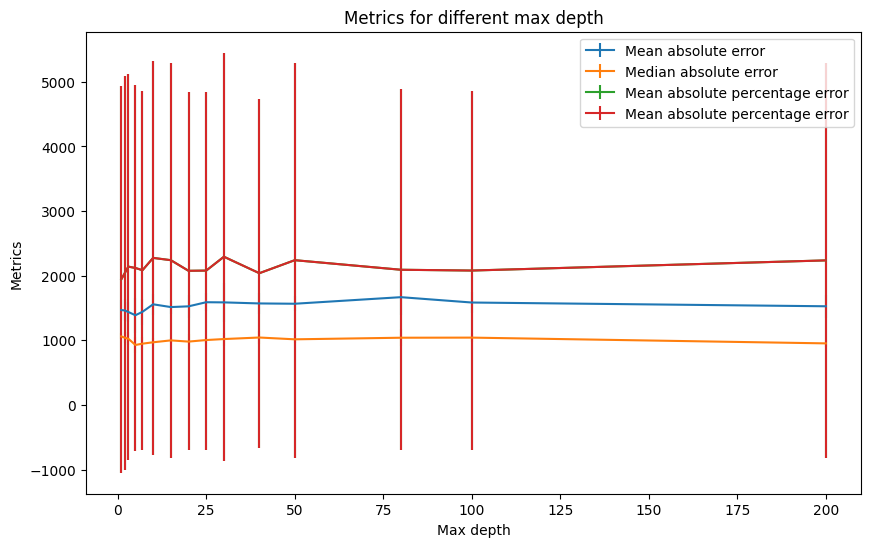

In [33]:
max_depth_tried = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 80, 100, 200]

tree_models_plot = {
    f"Tree with max depth {i}" : {
        "model": DecisionTreeRegressor(max_depth=i),
        } for i in neighbors_tried}

results_list_tree_models_plot = []

for model_name in tree_models_plot:
    print(model_name)
    model = tree_models_plot[model_name]["model"]

    results = train_and_get_metrics(model, X_train.sample(500, random_state=1), y_train.sample(500, random_state=1), verbose=False)
    results_list_tree_models_plot.append(results)

plt.figure(figsize=(10, 6))
plt.errorbar(max_depth_tried, [results["test_custom_1"] for results in results_list_tree_models_plot], 
             yerr=[results["test_custom_1_std"] for results in results_list_tree_models_plot], label="Custom 1")
plt.errorbar(max_depth_tried, [results["test_custom_5"] for results in results_list_tree_models_plot],
                yerr=[results["test_custom_5_std"] for results in results_list_tree_models_plot], label="Custom 5")
plt.errorbar(max_depth_tried, [results["test_custom_10"] for results in results_list_tree_models_plot],
                yerr=[results["test_custom_10_std"] for results in results_list_tree_models_plot], label="Custom 10")


plt.errorbar(max_depth_tried, [results["test_custom_20"] for results in results_list_tree_models_plot],
                yerr=[results["test_custom_20_std"] for results in results_list_tree_models_plot], label="Custom 20")
plt.xlabel("Max depth")
plt.ylabel("Custom metrics")
plt.legend()
plt.title("Custom metrics for different max depth")

plt.figure(figsize=(10, 6))
plt.errorbar(max_depth_tried, [results["test_explained_variance"] for results in results_list_tree_models_plot], 
             yerr=[results["test_explained_variance_std"] for results in results_list_tree_models_plot], label="Explained variance")
plt.errorbar(max_depth_tried, [results["test_r2"] for results in results_list_tree_models_plot],
                yerr=[results["test_r2_std"] for results in results_list_tree_models_plot], label="R2")
plt.xlabel("Max depth")
plt.ylabel("Metrics")
plt.legend()
plt.title("Metrics for different max depth")

# Now for ["test_mean_absolute_error", "test_median_absolute_error", "test_mape"]

plt.figure(figsize=(10, 6))
plt.errorbar(max_depth_tried, [results["test_mean_absolute_error"] for results in results_list_tree_models_plot], 
             yerr=[results["test_mean_absolute_error_std"] for results in results_list_tree_models_plot], label="Mean absolute error")
plt.errorbar(max_depth_tried, [results["test_median_absolute_error"] for results in results_list_tree_models_plot],
                yerr=[results["test_median_absolute_error_std"] for results in results_list_tree_models_plot], label="Median absolute error")
plt.errorbar(max_depth_tried, [results["test_mape"] for results in results_list_tree_models_plot],
                yerr=[results["test_mape_std"] for results in results_list_tree_models_plot], label="Mean absolute percentage error")

plt.errorbar(max_depth_tried, [results["test_mape"] for results in results_list_tree_models_plot],   
                yerr=[results["test_mape_std"] for results in results_list_tree_models_plot], label="Mean absolute percentage error")
plt.xlabel("Max depth")
plt.ylabel("Metrics")
plt.legend()
plt.title("Metrics for different max depth")


### Now get back to the tables (for Trees)

In [38]:
# Use the different entropies: {'friedman_mse', 'squared_error', 'absolute_error', 'poisson
tree_models = {
    "Tree friedman_mse (max_depth 5)" : {
        "model": DecisionTreeRegressor(max_depth=5, criterion="friedman_mse"),
        },
    "Tree squared_error (max_depth 5)" : {
        "model": DecisionTreeRegressor(max_depth=5, criterion="squared_error"),
        },
    "Tree absolute_error (max_depth 5)" : {
        "model": DecisionTreeRegressor(max_depth=5, criterion="absolute_error"),
        },
    "Tree friedman_mse (max_depth 10)" : {
        "model": DecisionTreeRegressor(max_depth=10, criterion="friedman_mse"),
        },
    "Tree squared_error (max_depth 10)" : {
        "model": DecisionTreeRegressor(max_depth=10, criterion="squared_error"),
        },
    "Tree absolute_error (max_depth 10)" : {
        "model": DecisionTreeRegressor(max_depth=10, criterion="absolute_error"),
        }}

results_list_tree_models = []

for model_name in tree_models:
    print(model_name)
    model = tree_models[model_name]["model"]

    results = train_and_get_metrics(model, X_train.sample(500, random_state=1), y_train.sample(500, random_state=1), verbose=False)
    results_list_tree_models.append(results)

filtered_results_tree = [filter_metrics(results) for results in results_list_tree_models]
format_results_df(filtered_results_tree, column_names=tree_models.keys())

Tree friedman_mse (max_depth 5)
Tree squared_error (max_depth 5)
Tree absolute_error (max_depth 5)
Tree friedman_mse (max_depth 10)
Tree squared_error (max_depth 10)
Tree absolute_error (max_depth 10)


,Tree friedman_mse (max_depth 5),Tree squared_error (max_depth 5),Tree absolute_error (max_depth 5),Tree friedman_mse (max_depth 10),Tree squared_error (max_depth 10),Tree absolute_error (max_depth 10)
test_explained_variance,-0.12 ± 0.25,-0.00 ± 0.37,0.22 ± 0.18,-0.14 ± 0.41,-0.31 ± 0.56,-0.29 ± 0.37
test_r2,-0.14 ± 0.27,-0.02 ± 0.39,0.21 ± 0.18,-0.16 ± 0.44,-0.34 ± 0.61,-0.32 ± 0.40
test_mape,2119.91 ± 2834.63,2120.19 ± 2835.13,1693.42 ± 2440.15,2044.11 ± 2712.60,2044.12 ± 2712.61,1681.40 ± 2355.03
test_median_absolute_error,928.69 ± 118.20,928.69 ± 118.20,855.57 ± 51.39,970.44 ± 48.65,957.82 ± 70.96,1088.45 ± 186.32
test_mean_absolute_error,1417.61 ± 219.53,1387.09 ± 268.14,1254.26 ± 134.26,1485.19 ± 137.30,1548.30 ± 219.81,1605.05 ± 204.96
test_mean_squared_log_error,0.72 ± 0.41,0.46 ± 0.52,0.43 ± 0.49,0.79 ± 0.72,0.82 ± 0.69,0.81 ± 0.68
test_custom_1,6.40 ± 3.01,6.40 ± 3.01,4.40 ± 1.62,6.00 ± 1.26,6.60 ± 2.15,4.00 ± 1.79
test_custom_5,24.60 ± 5.08,24.60 ± 5.08,26.00 ± 3.03,22.20 ± 2.56,23.60 ± 3.67,20.40 ± 2.58
test_custom_10,43.20 ± 3.97,43.20 ± 3.97,47.00 ± 3.22,41.80 ± 1.94,41.80 ± 2.79,39.40 ± 5.78
test_custom_20,71.00 ± 8.32,71.20 ± 8.38,74.20 ± 4.21,68.80 ± 2.04,67.40 ± 3.26,64.60 ± 7.61


## Random forests

In [40]:
forest_models = {
    "RF 100" : {
        "model": RandomForestRegressor(n_estimators=100),
        "use_probabilities": True,
        "convert_to_binary": False
        },
    "RF 50" : {
        "model": RandomForestRegressor(n_estimators=50),
        "use_probabilities": True,
        "convert_to_binary": False
        },
    "RF 200" : {
        "model": RandomForestRegressor(n_estimators=200),
        "use_probabilities": True,
        "convert_to_binary": False
        },
    "RF 500" : {
        "model": RandomForestRegressor(n_estimators=500),
        "use_probabilities": True,
        "convert_to_binary": False
        }}

results_list_forest_models = []

for model_name in forest_models:
    print(model_name)
    model = forest_models[model_name]["model"]

    results = train_and_get_metrics(model, X_train.sample(500, random_state=1), y_train.sample(500, random_state=1), verbose=False)
    results_list_forest_models.append(results)

filtered_results_forest = [filter_metrics(results) for results in results_list_forest_models]
format_results_df(filtered_results_forest, column_names=forest_models.keys())

RF 100


c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RF 50


c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RF 200


c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RF 500


c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

,RF 100,RF 50,RF 200,RF 500
test_explained_variance,0.38 ± 0.20,0.34 ± 0.21,0.36 ± 0.20,0.38 ± 0.21
test_r2,0.36 ± 0.20,0.33 ± 0.21,0.35 ± 0.20,0.36 ± 0.20
test_mape,2056.71 ± 2899.22,2018.11 ± 2849.16,2110.66 ± 3012.41,2045.22 ± 2881.39
test_median_absolute_error,751.05 ± 46.32,730.27 ± 37.88,708.04 ± 46.03,728.61 ± 18.80
test_mean_absolute_error,1107.97 ± 143.09,1139.59 ± 130.29,1120.85 ± 146.86,1110.49 ± 144.97
test_mean_squared_log_error,0.43 ± 0.50,0.44 ± 0.50,0.44 ± 0.51,0.43 ± 0.50
test_custom_1,6.80 ± 1.94,4.60 ± 2.06,5.80 ± 0.75,5.40 ± 2.06
test_custom_5,30.60 ± 4.13,28.00 ± 3.85,30.00 ± 3.29,29.80 ± 2.79
test_custom_10,51.60 ± 1.96,51.60 ± 1.62,52.00 ± 2.53,52.60 ± 1.50
test_custom_20,79.20 ± 3.60,77.80 ± 3.92,77.60 ± 4.13,79.20 ± 4.21
